MusicGen's FAD lowest than all other models including Suno and Udio. We investigate here.

In [1]:
!pip install resampy
!pip install frechet_audio_distance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 48.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 4.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of laion-clap to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [1]:
import torchaudio
import os
import random
import torch
import resampy
import numpy as np
import soundfile as sf
from multiprocessing.dummy import Pool as ThreadPool
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.cluster import KMeans

In [2]:
PROJECT_PATH = "/content/drive/MyDrive/Colab Notebooks/Project"
musiclm_audio_dir = f'{PROJECT_PATH}/Audible-Visual/open-musiclm/most_similar_output/1s_audio_every_500ms'
musicgen_audio_dir = f'{PROJECT_PATH}/Audible-Visual/musicgen/most_similar_output/1s_audio_every_500ms'
suno_audio_dir = f'{PROJECT_PATH}/Audible-Visual/suno/1s_audio_every_500ms'
udio_audio_dir = f'{PROJECT_PATH}/Audible-Visual/udio/1s_audio_every_500ms'
bg_audio_dir = f'{PROJECT_PATH}/FMA_INSTR/1s_audio_every_500ms'
bg_embs_save_path = f'{PROJECT_PATH}/Audible-Visual/fma_instr_bg_emb.npy'

In [3]:
def load_audio_task(fname, sample_rate, channels, dtype="float32"):
    if dtype not in ['float64', 'float32', 'int32', 'int16']:
        raise ValueError(f"dtype not supported: {dtype}")

    wav_data, sr = sf.read(fname, dtype=dtype)
    # For integer type PCM input, convert to [-1.0, +1.0]
    if dtype == 'int16':
        wav_data = wav_data / 32768.0
    elif dtype == 'int32':
        wav_data = wav_data / float(2**31)

    # Convert to mono
    assert channels in [1, 2], "channels must be 1 or 2"
    if len(wav_data.shape) > channels:
        wav_data = np.mean(wav_data, axis=1)

    if sr != sample_rate:
        wav_data = resampy.resample(wav_data, sr, sample_rate)

    return wav_data

def load_audio_files(frechet, dir, dtype="float32"):
    task_results = []

    pool = ThreadPool(frechet.audio_load_worker)
    pbar = tqdm(total=len(os.listdir(dir)), disable=(not frechet.verbose))

    def update(*a):
        pbar.update()

    if frechet.verbose:
        print("[Frechet Audio Distance] Loading audio from {}...".format(dir))
    for fname in os.listdir(dir):
        res = pool.apply_async(
            load_audio_task,
            args=(os.path.join(dir, fname), frechet.sample_rate, frechet.channels, dtype),
            callback=update,
        )
        task_results.append(res)
    pool.close()
    pool.join()

    return [k.get() for k in task_results]

In [4]:
from frechet_audio_distance import FrechetAudioDistance

# to use `vggish`
frechet = FrechetAudioDistance(
    model_name="vggish",
    sample_rate=16000,
    use_pca=False,
    use_activation=False,
    verbose=False
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/harritaylor/torchvggish/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/harritaylor/torchvggish/releases/download/v0.1/vggish-10086976.pth" to /root/.cache/torch/hub/checkpoints/vggish-10086976.pth
100%|██████████| 275M/275M [00:02<00:00, 133MB/s] 
Downloading: "https://github.com/h

In [5]:
bg_embs = np.load(bg_embs_save_path)
print(bg_embs.shape)
bg_mu, bg_sigma = frechet.calculate_embd_statistics(bg_embs)
print(bg_mu.shape, bg_sigma.shape)

(3100, 128)
(128,) (128, 128)


In [6]:
musiclm_audio = load_audio_files(frechet, musiclm_audio_dir)
musiclm_embs = frechet.get_embeddings(musiclm_audio, frechet.sample_rate)
musiclm_mu, musiclm_sigma = frechet.calculate_embd_statistics(musiclm_embs)

In [ ]:
musicgen_audio = load_audio_files(frechet, musicgen_audio_dir)
musicgen_embs = frechet.get_embeddings(musicgen_audio, frechet.sample_rate)
musicgen_mu, musicgen_sigma = frechet.calculate_embd_statistics(musicgen_embs)

In [ ]:
suno_audio = load_audio_files(frechet, suno_audio_dir)
suno_embs = frechet.get_embeddings(suno_audio, frechet.sample_rate)
suno_mu, suno_sigma = frechet.calculate_embd_statistics(suno_embs)

In [ ]:
udio_audio = load_audio_files(frechet, udio_audio_dir)
udio_embs = frechet.get_embeddings(udio_audio, frechet.sample_rate)
udio_mu, udio_sigma = frechet.calculate_embd_statistics(udio_embs)

#PCA 3100 128d vector and plot

In [ ]:
pca = PCA(n_components=2)
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto")

##Background (FMA_INSTR)

In [ ]:
bg_embs_fit = pca.fit_transform(bg_embs)
bg_embs_fit.shape
bg_clusters  = kmeans.fit(bg_embs_fit).cluster_centers_

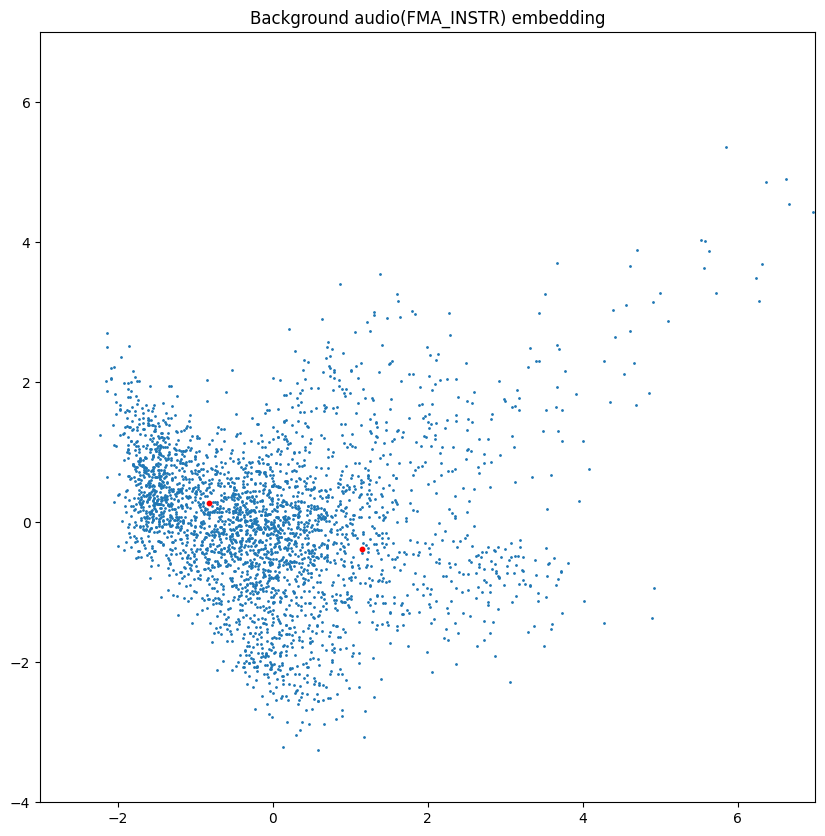

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))

ax.scatter(bg_embs_fit[:,0], bg_embs_fit[:,1], s=1)
ax.scatter(bg_clusters[:,0], bg_clusters[:,1], s=10, c="red")
ax.set_title("Background audio(FMA_INSTR) embedding")
ax.set_xlim([-3,7])
ax.set_ylim([-4,7])
plt.show()

##Open-MusicLM

In [ ]:
musiclm_embs_fit = pca.fit_transform(musiclm_embs)
print(musiclm_embs_fit.shape)
musiclm_clusters  = kmeans.fit(musiclm_embs_fit).cluster_centers_

(750, 2)


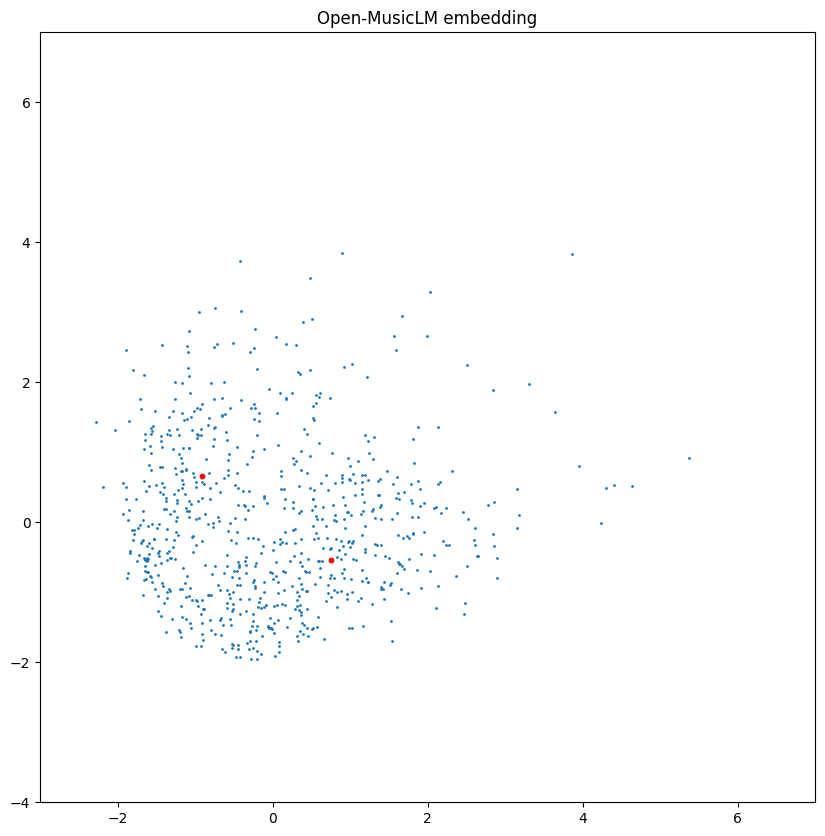

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))

ax.scatter(musiclm_embs_fit[:,0], musiclm_embs_fit[:,1], s=1)
ax.scatter(musiclm_clusters[:,0], musiclm_clusters[:,1], s=10, c="red")
ax.set_title("Open-MusicLM embedding")
ax.set_xlim([-3,7])
ax.set_ylim([-4,7])
plt.show()

##MusicGen

In [ ]:
musicgen_embs_fit = pca.fit_transform(musicgen_embs)
print(musicgen_embs_fit.shape)
musicgen_clusters  = kmeans.fit(musicgen_embs_fit).cluster_centers_

(750, 2)


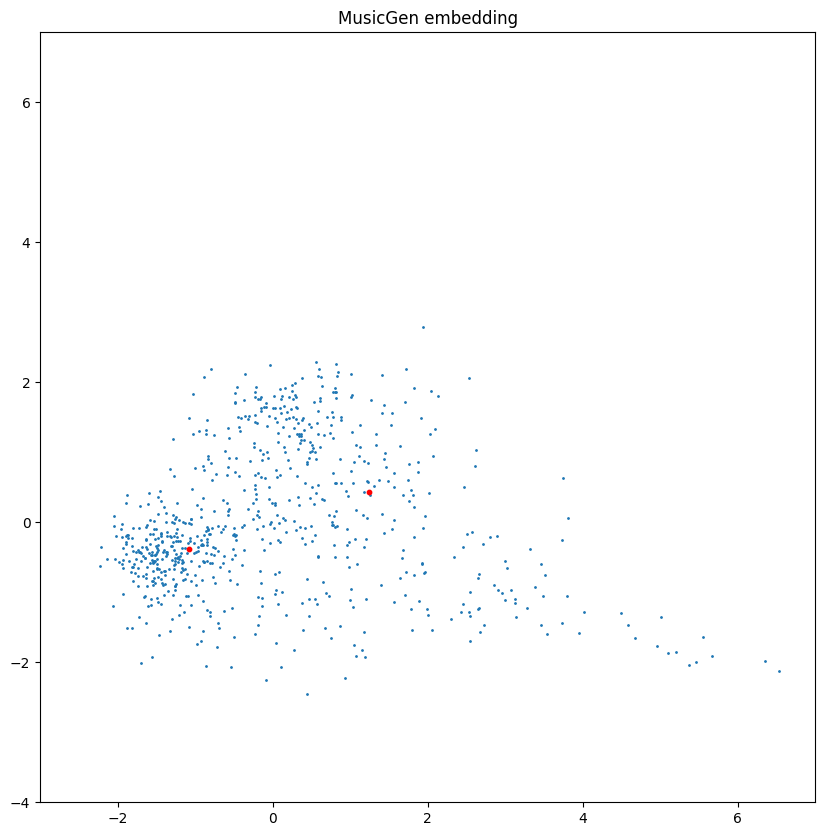

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))

ax.scatter(musicgen_embs_fit[:,0], musicgen_embs_fit[:,1], s=1)
ax.scatter(musicgen_clusters[:,0], musicgen_clusters[:,1], s=10, c="red")
ax.set_title("MusicGen embedding")
ax.set_xlim([-3,7])
ax.set_ylim([-4,7])
plt.show()

##Suno

In [ ]:
suno_embs_fit = pca.fit_transform(suno_embs)
print(suno_embs_fit.shape)
suno_clusters  = kmeans.fit(suno_embs_fit).cluster_centers_

(375, 2)


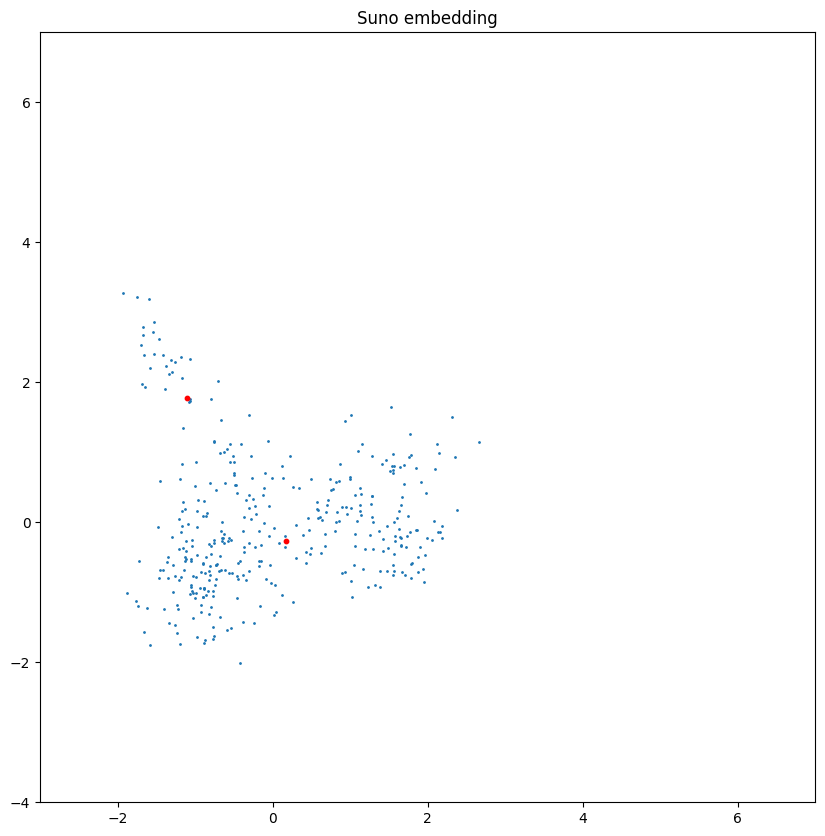

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))

ax.scatter(suno_embs_fit[:,0], suno_embs_fit[:,1], s=1)
ax.scatter(suno_clusters[:,0], suno_clusters[:,1], s=10, c="red")
ax.set_title("Suno embedding")
ax.set_xlim([-3,7])
ax.set_ylim([-4,7])
plt.show()

##Udio

In [ ]:
udio_embs_fit = pca.fit_transform(udio_embs)
print(udio_embs_fit.shape)
udio_clusters  = kmeans.fit(udio_embs_fit).cluster_centers_

(750, 2)


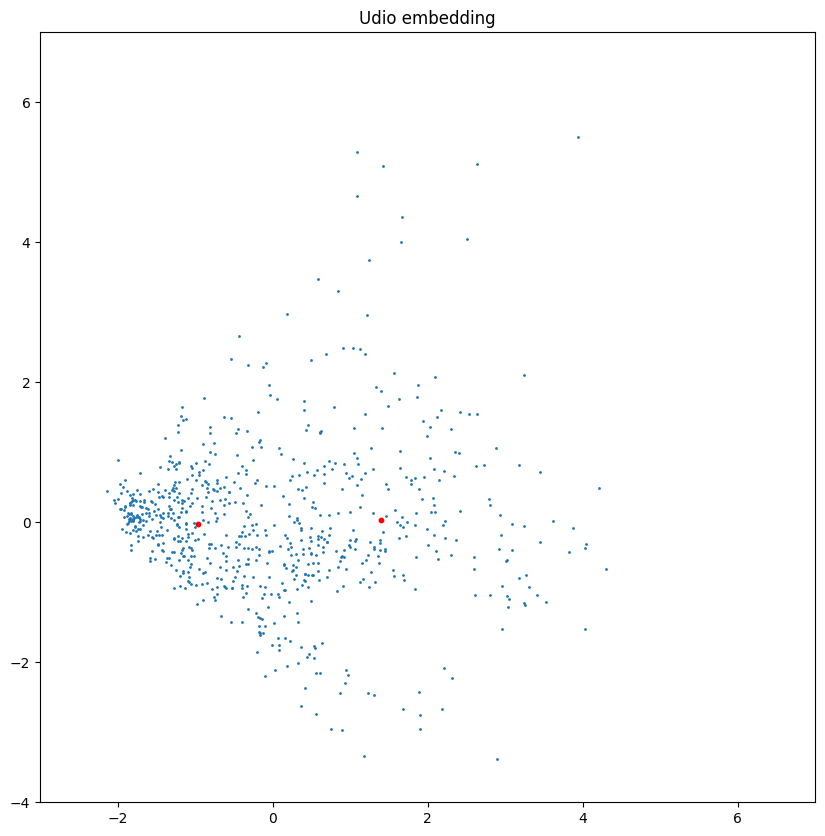

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))

ax.scatter(udio_embs_fit[:,0], udio_embs_fit[:,1], s=1)
ax.scatter(udio_clusters[:,0], udio_clusters[:,1], s=10, c="red")
ax.set_title("Udio embedding")
ax.set_xlim([-3,7])
ax.set_ylim([-4,7])
plt.show()

#FAD see

In [ ]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
        """
        Adapted from: https://github.com/mseitzer/pytorch-fid/blob/master/src/pytorch_fid/fid_score.py

        Numpy implementation of the Frechet Distance.
        The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
        and X_2 ~ N(mu_2, C_2) is
                d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
        Stable version by Dougal J. Sutherland.
        Params:
        -- mu1   : Numpy array containing the activations of a layer of the
                inception net (like returned by the function 'get_predictions')
                for generated samples.
        -- mu2   : The sample mean over activations, precalculated on an
                representative data set.
        -- sigma1: The covariance matrix over activations for generated samples.
        -- sigma2: The covariance matrix over activations, precalculated on an
                representative data set.
        Returns:
        --   : The Frechet Distance.
        """

        mu1 = np.atleast_1d(mu1)
        mu2 = np.atleast_1d(mu2)

        sigma1 = np.atleast_2d(sigma1)
        sigma2 = np.atleast_2d(sigma2)

        assert mu1.shape == mu2.shape, \
            'Training and test mean vectors have different lengths'
        assert sigma1.shape == sigma2.shape, \
            'Training and test covariances have different dimensions'

        diff = mu1 - mu2

        # Product might be almost singular
        covmean, _ = linalg.sqrtm(sigma1.dot(sigma2).astype(complex), disp=False)
        if not np.isfinite(covmean).all():
            msg = ('fid calculation produces singular product; '
                   'adding %s to diagonal of cov estimates') % eps
            print(msg)
            offset = np.eye(sigma1.shape[0]) * eps
            covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset).astype(complex))

        # Numerical error might give slight imaginary component
        if np.iscomplexobj(covmean):
            if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
                m = np.max(np.abs(covmean.imag))
                raise ValueError('Imaginary component {}'.format(m))
            covmean = covmean.real

        tr_covmean = np.trace(covmean)

        return (diff.dot(diff)), (np.trace(sigma1)
                + np.trace(sigma2) - 2 * tr_covmean)

Open-MusicLM

In [ ]:
diff_dot, trace = calculate_frechet_distance(musiclm_mu, musiclm_sigma, bg_mu, bg_sigma)
print(diff_dot)
print(trace)

6.598634
4.8170990120253471753


MusicGen

In [ ]:
diff_dot, trace = calculate_frechet_distance(musicgen_mu, musicgen_sigma, bg_mu, bg_sigma)
print(diff_dot)
print(trace)

0.46362913
1.9334855100075291102


Suno

In [ ]:
diff_dot, trace = calculate_frechet_distance(suno_mu, suno_sigma, bg_mu, bg_sigma)
print(diff_dot)
print(trace)

1.0856727
2.9553235595019522342


Udio

In [ ]:
diff_dot, trace = calculate_frechet_distance(udio_mu, udio_sigma, bg_mu, bg_sigma)
print(diff_dot)
print(trace)

0.97074217
2.2383153187932077026


#Plot mean

In [ ]:
x = [i for i in range(1,129)]

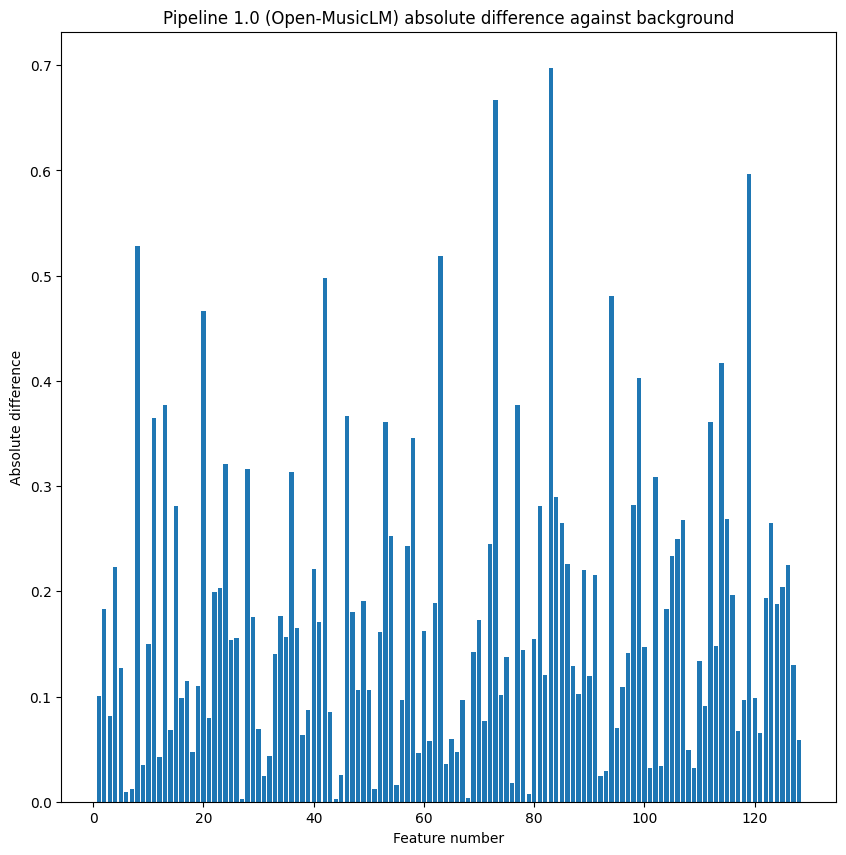

In [ ]:
#MusicLM-Background
diff = np.abs(bg_mu - musiclm_mu)

fig,ax = plt.subplots(figsize=(10,10))
ax.set_xlabel("Feature number")
ax.set_ylabel("Absolute difference")
ax.set_title("Pipeline 1.0 (Open-MusicLM) absolute difference against background")
ax.bar(x, diff)
plt.show()

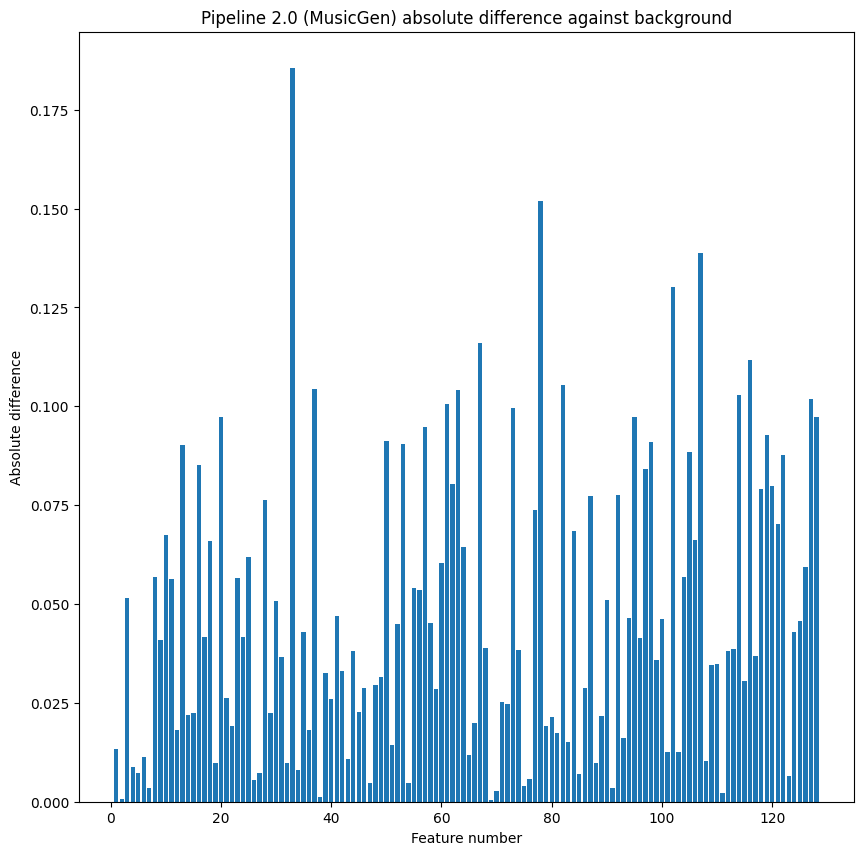

In [ ]:
#MusicGen-Background
diff = np.abs(bg_mu - musicgen_mu)

fig,ax = plt.subplots(figsize=(10,10))
ax.set_xlabel("Feature number")
ax.set_ylabel("Absolute difference")
ax.set_title("Pipeline 2.0 (MusicGen) absolute difference against background")
ax.bar(x, diff)
plt.show()

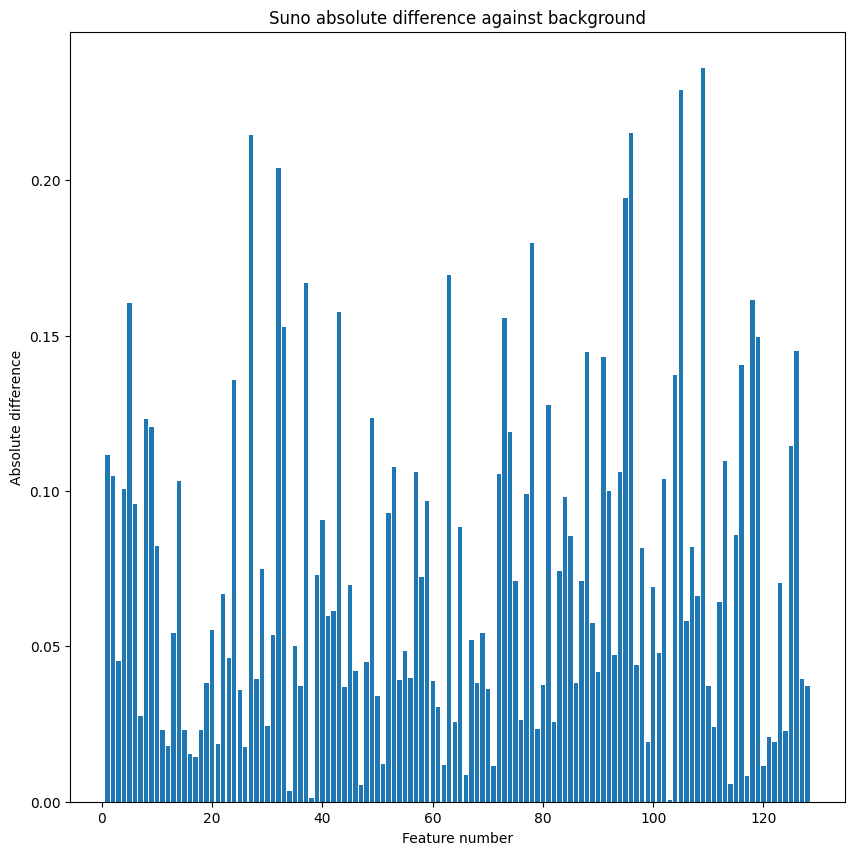

In [ ]:
#Suno-background
diff = np.abs(bg_mu - suno_mu)
fig,ax = plt.subplots(figsize=(10,10))
ax.set_xlabel("Feature number")
ax.set_ylabel("Absolute difference")
ax.set_title("Suno absolute difference against background")
ax.bar(x, diff)
plt.show()

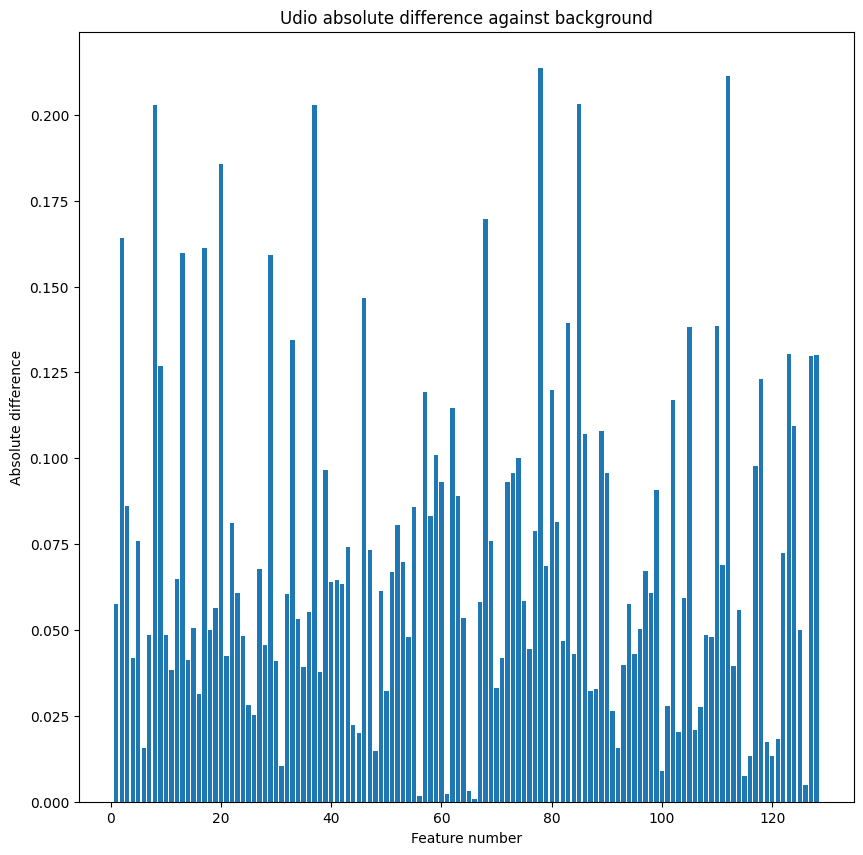

In [ ]:
#Udio-Background
diff = np.abs(bg_mu-udio_mu)
fig,ax = plt.subplots(figsize=(10,10))
ax.set_xlabel("Feature number")
ax.set_ylabel("Absolute difference")
ax.set_title("Udio absolute difference against background")
ax.bar(x, diff)
plt.show()